# Pareto NBD Model

In this notebook we show how to fit a Pareto/NBD model in PyMC-Marketing. We compare the results with the [`lifetimes`](https://github.com/CamDavidsonPilon/lifetimes) package (no longer maintained). The model is presented in the paper: Schmittlein, David C., Donald G. Morrison, and Richard Colombo (1987), *“Counting Your Customers: Who Are They and What Will They Do Next?”* Management Science, 33 (January), 1–24.

## Prepare Notebook

In [30]:
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from lifetimes import ParetoNBDFitter

from pymc_marketing import clv

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

The autoreload extension is already loaded. To reload it, use:

%reload_ext autoreload

## Read Data

We use the `CDNOW` dataset (see lifetimes [quick-start](https://lifetimes.readthedocs.io/en/latest/Quickstart.html)).

In [2]:
data_path = "https://raw.githubusercontent.com/pymc-labs/pymc-marketing/main/data/clv_quickstart.csv"

df = pd.read_csv(data_path)

df.head()

,frequency,recency,T,monetary_value
0,2,30.43,38.86,22.35
1,1,1.71,38.86,11.77
2,0,0.00,38.86,0.00
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00


Recall from the `lifetimes` documentation the following definitions:

> - `frequency` represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
> - `T` represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
> - `recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

```{tip}
We rename the index column to `customer_id` as this is required by the model
```

In [3]:
data = (
    df.reset_index()
    .rename(columns={"index": "customer_id"})
    .drop(columns="monetary_value")
)

## Model Specification

The Pareto/NBD model is a probabilistic model that describes the buying behavior of a customer in the non-contractual setting. It is based on the following assumptions for each customer:

### Frequency Process

1. While active, the time between transactions is distributed exponential with transaction rate, i.e., 

    $$f(t_{j}|t_{j-1}; \lambda) = \lambda \exp(-\lambda (t_{j} - t_{j - 1})), \quad t_{j} \geq t_{j - 1} \geq 0$$ 

2. Heterogeneity in $\lambda$ follows a gamma distribution with pdf

    $$f(\lambda|r, \alpha) = \frac{\alpha^{r}\lambda^{r - 1}\exp(-\lambda \alpha)}{\Gamma(r)}, \quad \lambda  > 0$$

### Dropout Process

3.  A customer’s unobserved *lifetime8 of length $\tau$ (after which he is viewed as being inactive) is exponentially distributed with dropout rate $\mu$:

    $$f(\tau | \mu) = \mu \exp(-\mu \tau), \quad \tau \geq 0$$


4. Heterogeneity in $\tau$ follows a gamma distribution with pdf

    $$f(\mu|s, \beta) = \frac{\beta^{s}\mu^{s - 1}\exp(-\mu \beta)}{\Gamma(s)}, \quad \mu > 0$$

5. The transaction rate $\lambda$ and the dropout rate $\tau$ vary independently across customers.

Instead of estimating $\lambda$ and $\tau$ for each specific customer, we do it for a randomly chosen customer, i.e. we work with the expected values of the parameters. Hence, we are interesting in finding the posterior distribution of the parameters $r$, $\alpha$, $s$, and $\beta$.

## Model Fitting

Estimating such parameters is very easy in PyMC-Marketing. We instantiate the model in a similar way:

In [4]:
model_mcmc = clv.ParetoNBDModel(data=data)

We can *build* the model so that we can see the model specification:

In [5]:
model_mcmc.build_model()
print(model_mcmc)

Pareto/NBD
                r ~ Weibull(2, 1)
            alpha ~ Weibull(2, 10)
                s ~ Weibull(2, 1)
             beta ~ Weibull(2, 10)
recency_frequency ~ ParetoNBD(r, alpha, s, beta, <constant>)


We can now fit the model.

```{note}
It is not necessary to build the model before fitting it. We can fit the model directly.
```

In [16]:
sample_kwargs = {
    "draws": 1_000,
    "chains": 3,
    "target_accept": 0.8,
    "random_seed": 42,
}

idata_mcmc = model_mcmc.fit(fit_method="mcmc", **sample_kwargs)

/Users/juanitorduz/micromamba/envs/pymc-marketing-dev/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/juanitorduz/micromamba/envs/pymc-marketing-dev/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/juanitorduz/micromamba/envs/pymc-marketing-dev/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/juanitorduz/micromamba/envs/pymc-marketing-dev/lib/pytho

Output()

Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 548 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [17]:
idata_mcmc

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> fit_data

In [18]:
model_mcmc.fit_summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
r,0.562,0.046,0.488,0.662,0.001,0.001,1157.0,1134.0,1.0
alpha,10.694,0.848,9.135,12.328,0.025,0.018,1221.0,1272.0,1.0
s,0.605,0.115,0.411,0.835,0.003,0.002,1237.0,1532.0,1.0
beta,11.598,3.560,5.563,18.315,0.104,0.073,1152.0,1242.0,1.0


We see that the `r_hat` values are close to $1$, which indicates convergence. 

We can also plot posterior distributions of the parameters and the rank plots:

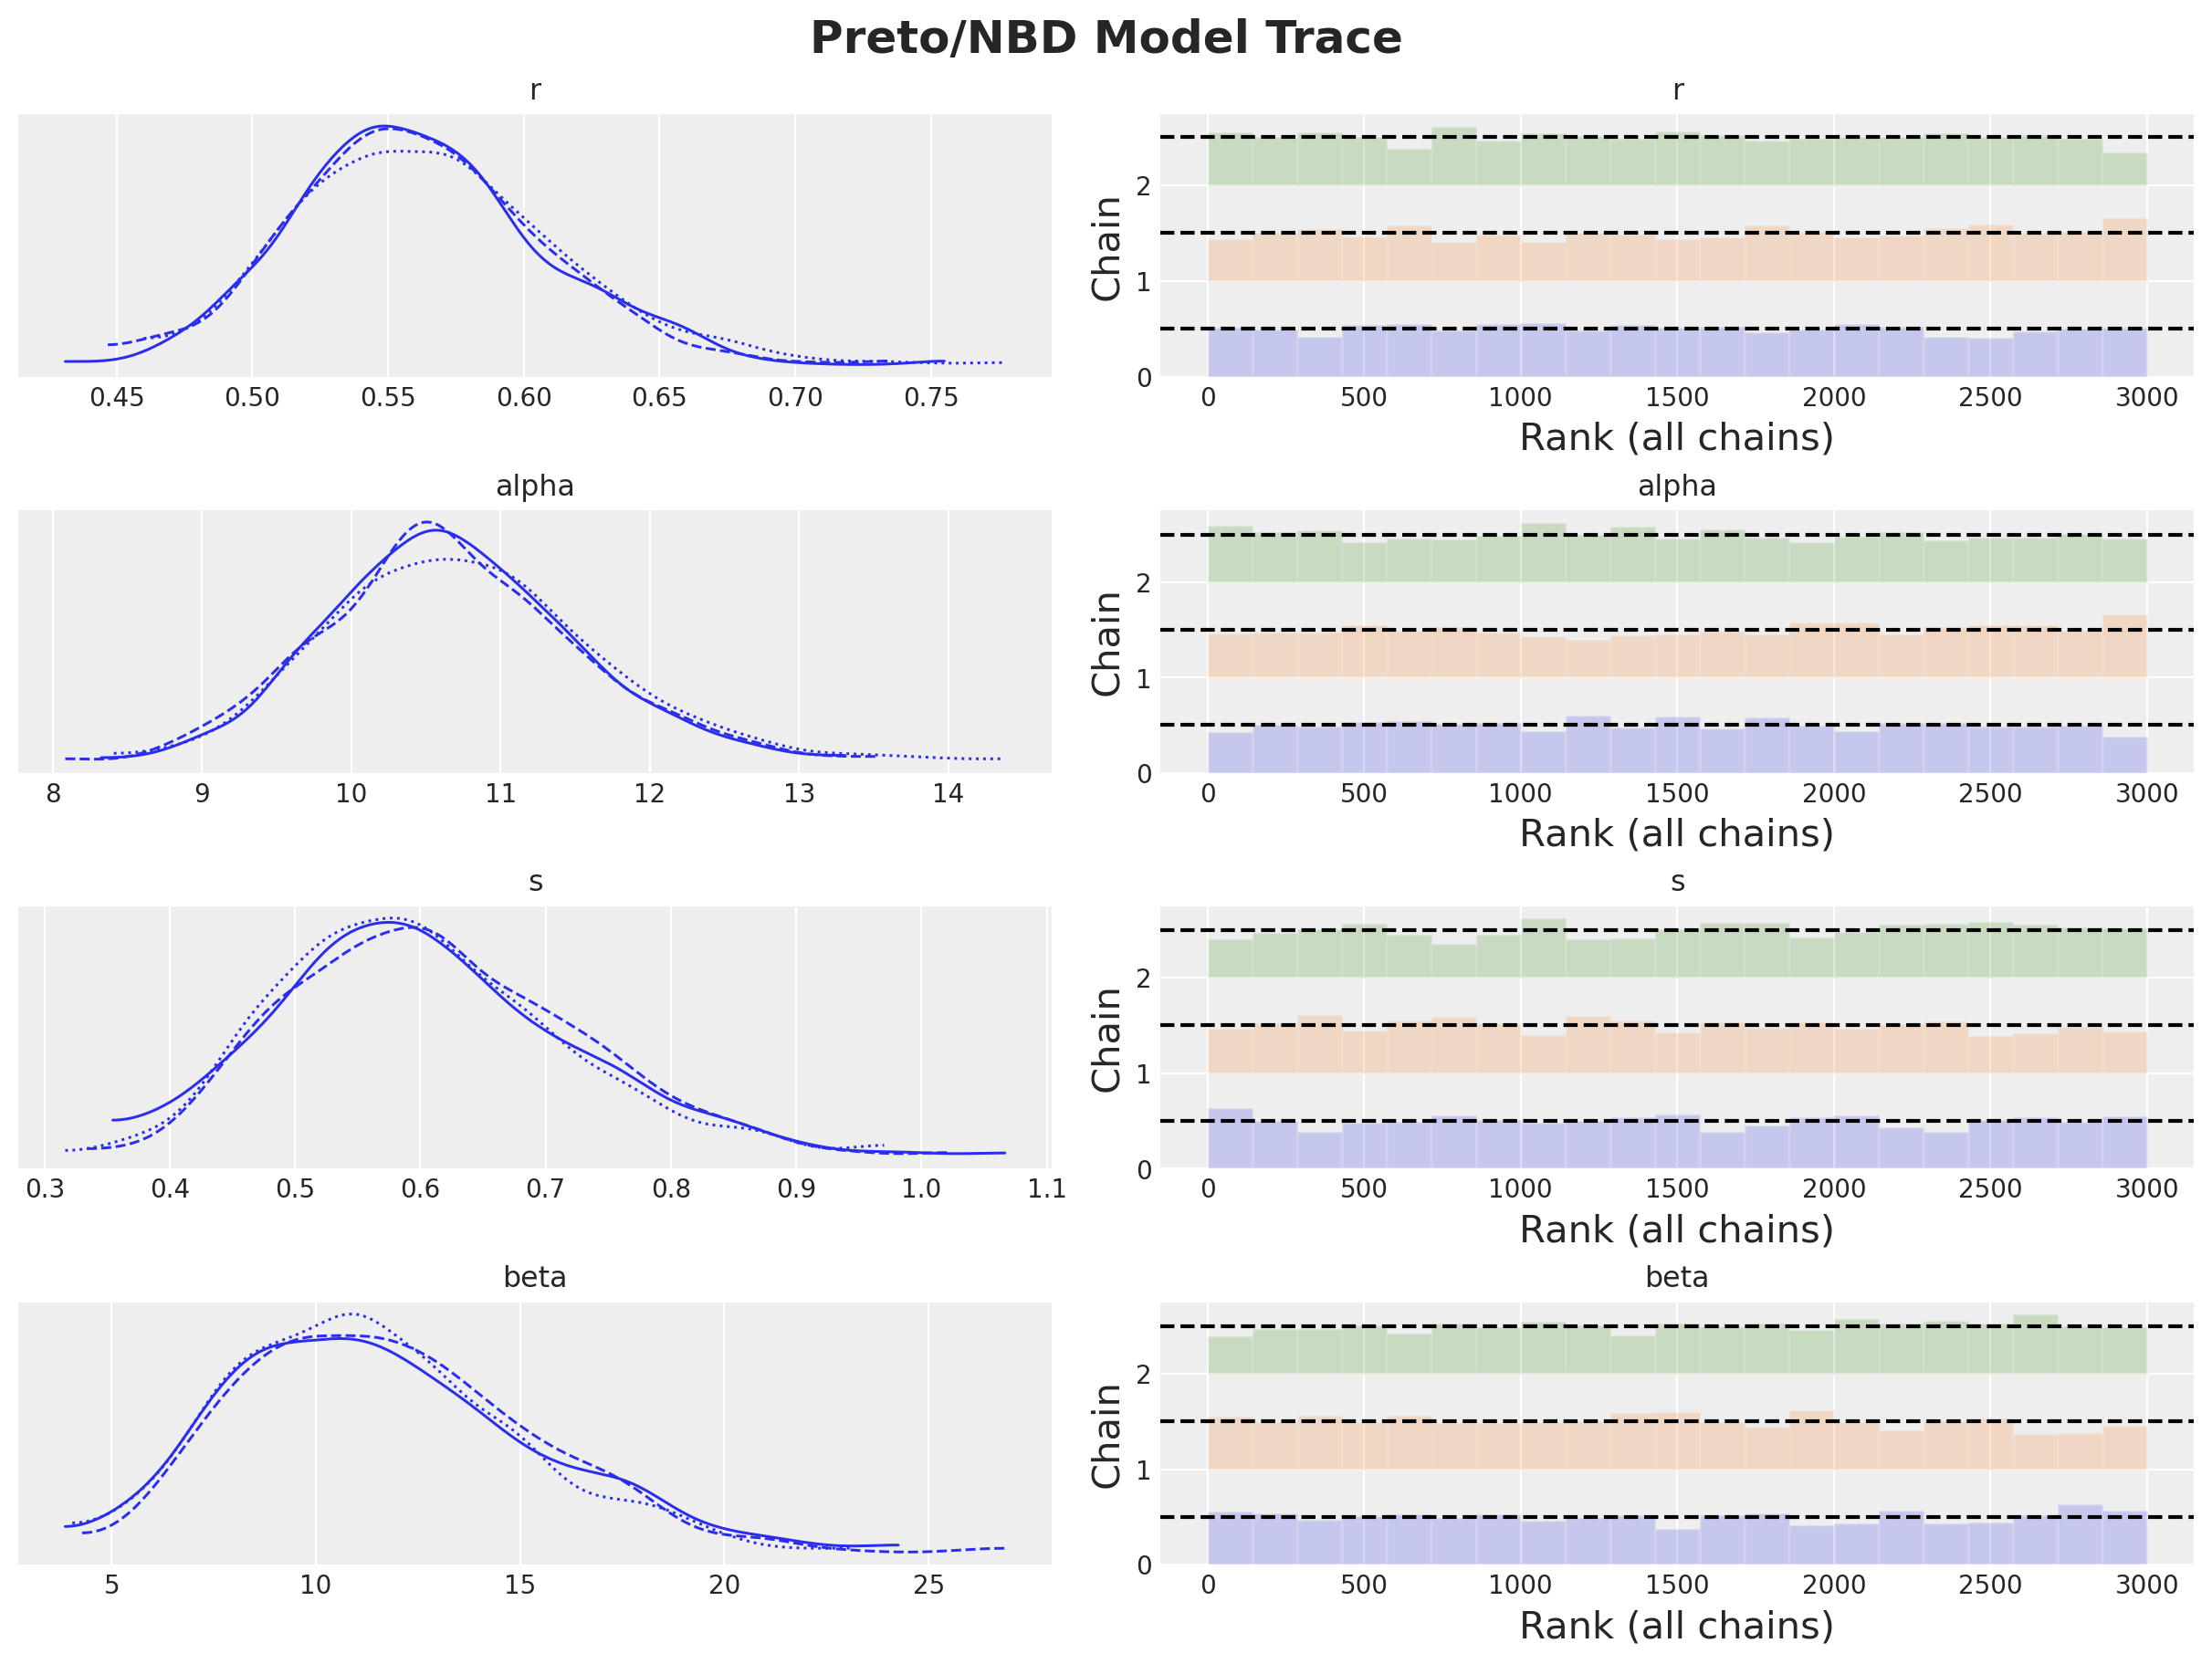

In [19]:
axes = az.plot_trace(
    data=model_mcmc.idata,
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Preto/NBD Model Trace", fontsize=18, fontweight="bold");

### Using MAP fit

CLV models such as `ParetoNBDModel`, can provide the maximum a posteriori estimates using a numerical optimizer (`L-BFGS-B`) from `scipy.optimize` under the hood.

In [20]:
model_map = clv.ParetoNBDModel(data=data)
idata_map = model_map.fit(fit_method="map")

/Users/juanitorduz/micromamba/envs/pymc-marketing-dev/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/juanitorduz/micromamba/envs/pymc-marketing-dev/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/juanitorduz/micromamba/envs/pymc-marketing-dev/lib/python3.10/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op hyp2f1 does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(


Output()

In [21]:
idata_map

Inference data with groups:
	> posterior
	> observed_data
	> fit_data

This time we get point estimates for the parameters.

In [22]:
map_summary = model_map.fit_summary()

map_summary

r         0.560
alpha    10.591
s         0.550
beta      9.756
Name: value, dtype: float64

## Comparing with the `lifetimes` package

For the sake of comparison, we also fit the model using the `lifetimes` package.

In [23]:
pareto = ParetoNBDFitter()
pareto.fit(
    frequency=data["frequency"].values,
    recency=data["recency"].values,
    T=data["T"].values,
)

pareto

<lifetimes.ParetoNBDFitter: fitted with 2357 subjects, alpha: 10.58, beta: 11.67, r: 0.55, s: 0.61>

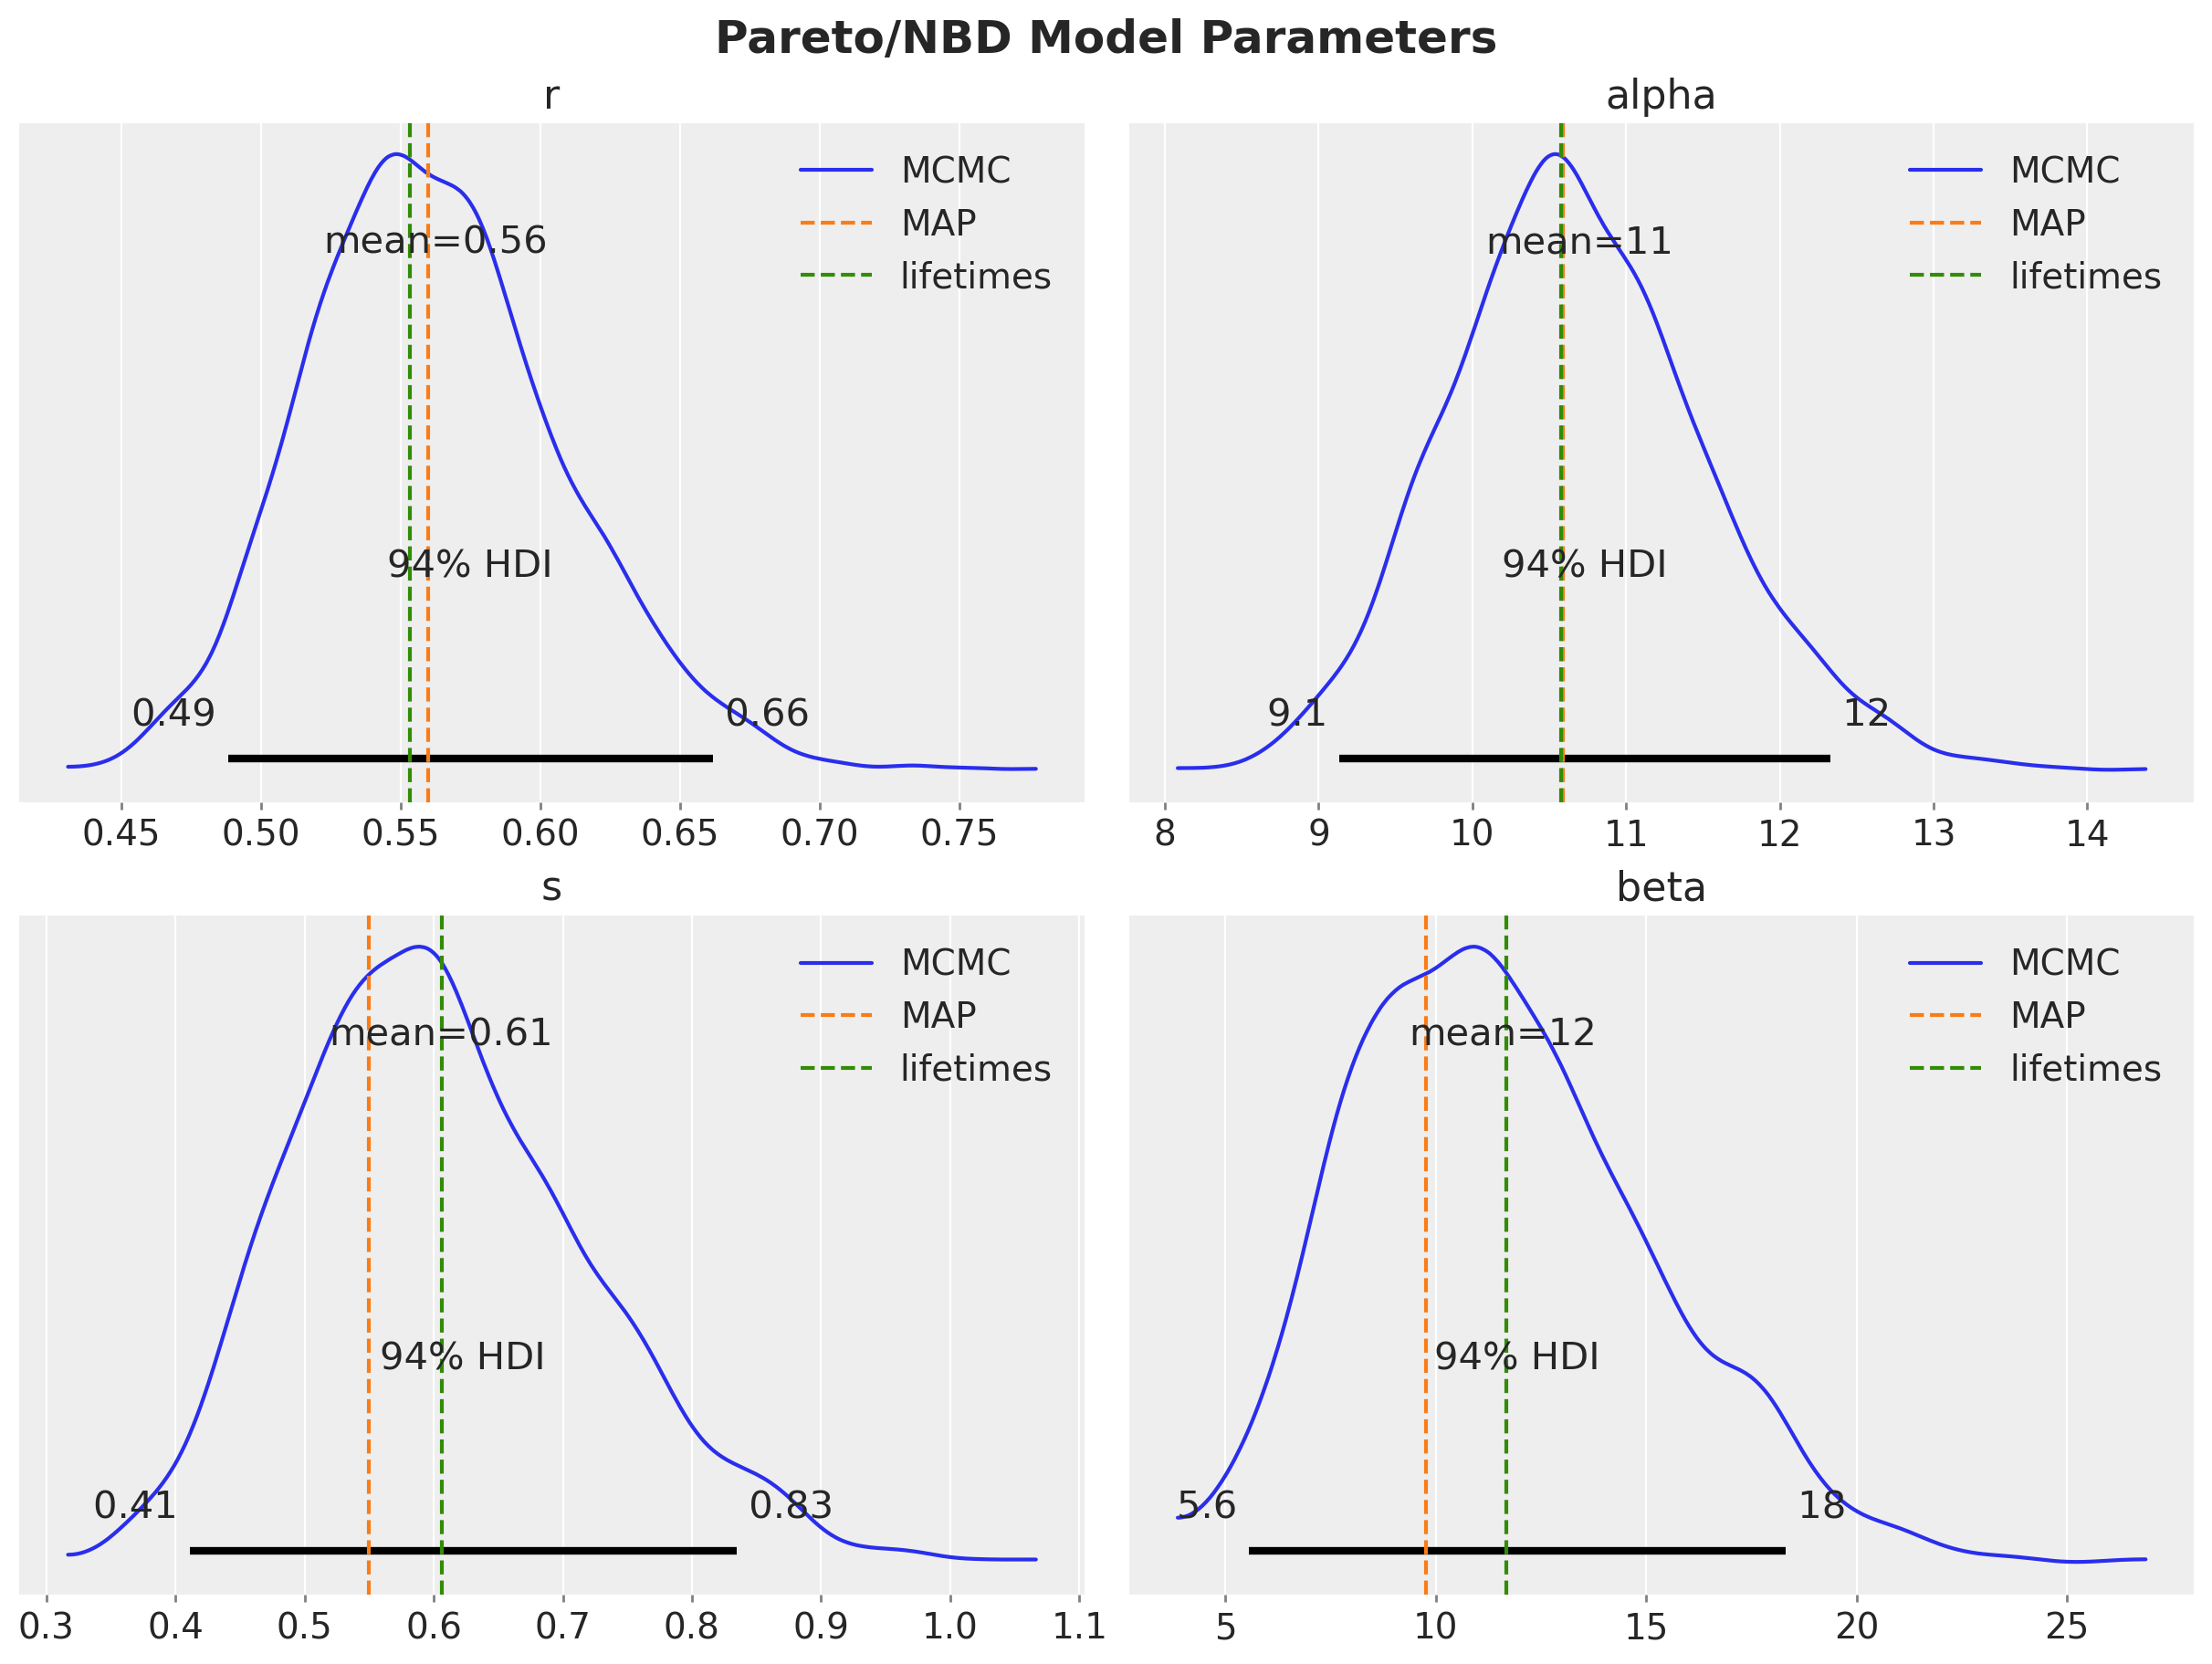

In [26]:
fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 9), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for i, var_name in enumerate(["r", "alpha", "s", "beta"]):
    ax = axes[i]
    az.plot_posterior(
        model_mcmc.idata.posterior[var_name].values.flatten(),
        color="C0",
        point_estimate="mean",
        ax=ax,
        label="MCMC",
    )
    ax.axvline(x=map_summary[var_name], color="C1", linestyle="--", label="MAP")
    ax.axvline(
        x=pareto.params_[var_name], color="C2", linestyle="--", label="lifetimes"
    )
    ax.legend(loc="upper right")
    ax.set_title(var_name)

plt.gcf().suptitle("Pareto/NBD Model Parameters", fontsize=18, fontweight="bold");

In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Mon Apr 15 2024

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.22.2

pymc    : 5.13.0
pytensor: 2.20.0

matplotlib    : 3.8.3
arviz         : 0.17.1
pymc_marketing: 0.4.2
pandas        : 2.2.1
xarray        : 2024.3.0

Watermark: 2.4.3